In [20]:
# Core data manipulation and analysis
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

# Statistical analysis
from scipy import stats
from scipy.stats import mannwhitneyu, bootstrap

# Set styling for publication-quality figures
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 11

# Pandas display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.precision', 3)

# Set random seed for reproducibility
np.random.seed(42)

print("✓ All dependencies loaded successfully")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")

✓ All dependencies loaded successfully
  pandas: 2.3.3
  numpy: 2.4.1


In [21]:
# Load data
df = pd.read_csv('../outputs/preprocessed.csv')

print(f"Total rows: {len(df):,}")
print(f"Columns: {len(df.columns)}")
print(f"\nSample of dataset_name and dataset_size:")
print(df[['dataset_name', 'dataset_size']].drop_duplicates().sort_values('dataset_name'))
print(f"\nDataset size statistics:")
print(df['dataset_size'].describe())
print(f"\nFirst few rows:")
df.head(5)

Total rows: 840
Columns: 33

Sample of dataset_name and dataset_size:
                             dataset_name  dataset_size
281         3D Dense Clusters (1K points)          1000
0           Iris Dataset (150 points, 4D)           150
280          MNIST-like (1K points, 784D)          1000
141         Medium Clustered (600 points)           600
1                Small Random (80 points)            80
140  Swiss Roll (600 points, 3D manifold)           600

Dataset size statistics:
count     840.000
mean      571.667
std       362.634
min        80.000
25%       150.000
50%       600.000
75%      1000.000
max      1000.000
Name: dataset_size, dtype: float64

First few rows:


,generated_at,runs_declared,result_run,result_duration_ms,stats_start_time,stats_duration_ms,wasm_features_file,wasm_preload,machine_platform,machine_release,machine_arch,cpu_model,cpu_cores,total_mem_bytes,load_avg_1,load_avg_5,load_avg_15,hostname,git_commit,git_branch,git_status_dirty,dataset_index,timestamp,dataset_name,dataset_size,dimensions,wasm_features,rendering_enabled,runtime_ms,memory_delta_mb,trustworthiness,fps_avg,responsiveness_ms
0,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:09.350Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2395.8,3.004,0.986,60.000,9.791
1,2026-02-06T11:20:33.775Z,10,1,42009,2026-02-06T11:20:49.897Z,26357.105,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:15.865Z,Small Random (80 points),80,10,none,False,3271.7,8.117,0.880,49.222,21.187
2,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:21:50.238Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2388.4,1.363,0.989,59.994,9.682
3,2026-02-06T11:20:33.775Z,10,2,41022,2026-02-06T11:21:30.915Z,27077.329,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,2,2026-02-06T11:21:56.264Z,Small Random (80 points),80,10,none,False,3538.4,8.718,0.868,46.995,23.280
4,2026-02-06T11:20:33.775Z,10,3,39489,2026-02-06T11:22:12.441Z,25040.741,none,True,linux,6.6.87.2-microsoft-standard-WSL2,x64,Intel(R) Core(TM) i7-10750H CPU @ 2.60GHz,12,8240963584,1.32,0.65,0.87,DESKTOP-7R7IE5L,eb9c07f4c9fff0ca6b5d0b0778ace9aac90031a6,clean-bench-data,True,1,2026-02-06T11:22:30.309Z,"Iris Dataset (150 points, 4D)",150,4,none,False,2375.8,0.014,0.989,59.994,8.155


In [22]:
# Standardize column names and prepare data
df_clean = df.copy()

# Create standardized feature column
# Handle comma-separated features (all features combined) and convert to lowercase
df_clean['feature'] = df_clean['wasm_features'].fillna('none').str.lower().str.strip()

# Map comma-separated features to 'all'
df_clean.loc[df_clean['feature'].str.contains(',', na=False), 'feature'] = 'all'

# Standardize feature names
feature_map = {
    'none': 'Baseline (JS)',
    'dist': 'Distance',
    'tree': 'Tree',
    'matrix': 'Matrix',
    'nn': 'NN Descent',
    'opt': 'Optimizer',
    'all': 'All Features'
}
df_clean['feature_name'] = df_clean['feature'].map(feature_map)

# Normalize rendering_enabled from data
# Accepts booleans, 0/1, or common strings
df_clean['rendering_enabled'] = (
    df_clean['rendering_enabled']
    .astype(str)
    .str.lower()
    .map({'true': True, 'false': False, '1': True, '0': False, 'yes': True, 'no': False})
)

# Convert numeric columns
numeric_cols = ['runtime_ms', 'memory_delta_mb', 'trustworthiness', 'fps_avg', 'responsiveness_ms']
for col in numeric_cols:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# Remove missing values in key columns
df_clean = df_clean.dropna(subset=['runtime_ms', 'feature_name'])

print(f"\nAfter cleaning: {len(df_clean):,} rows")
print(f"\nFeature distribution:")
print(df_clean['feature_name'].value_counts().sort_index())
print(f"\nRendering enabled distribution:")
print(df_clean['rendering_enabled'].value_counts(dropna=False))
print(f"\nDataset distribution:")
print(df_clean['dataset_name'].value_counts())



After cleaning: 840 rows

Feature distribution:
feature_name
All Features     120
Baseline (JS)    120
Distance         120
Matrix           120
NN Descent       120
Optimizer        120
Tree             120
Name: count, dtype: int64

Rendering enabled distribution:
rendering_enabled
False    460
True     380
Name: count, dtype: int64

Dataset distribution:
dataset_name
Iris Dataset (150 points, 4D)           140
Small Random (80 points)                140
Swiss Roll (600 points, 3D manifold)    140
Medium Clustered (600 points)           140
MNIST-like (1K points, 784D)            140
3D Dense Clusters (1K points)           140
Name: count, dtype: int64


Baseline (JS) runs: 120
  With rendering: 60
  Without rendering: 60

Metrics to plot: ['Runtime (ms)', 'Memory Delta (MB)', 'Average FPS', 'Responsiveness (ms)', 'Trustworthiness']


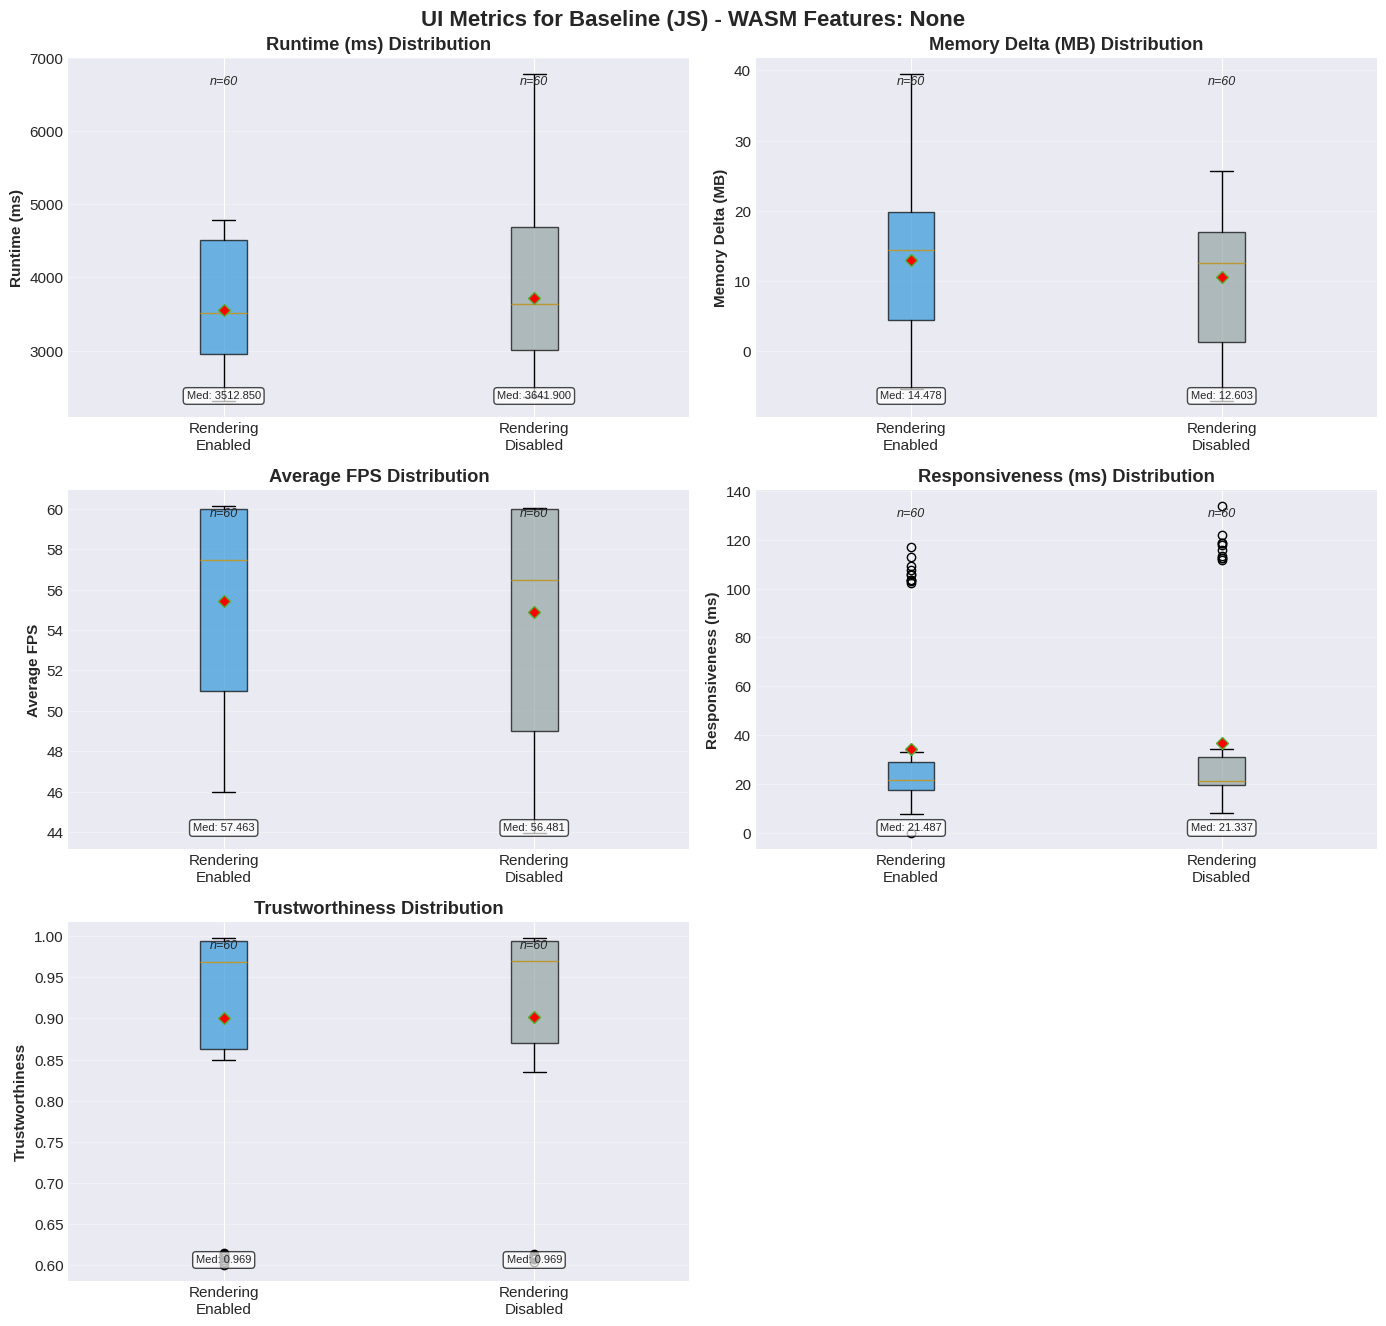


SUMMARY STATISTICS - Baseline (JS) with WASM Features: None

Runtime (ms):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 3552.0033, Median: 3512.8500, Std: 827.6343
    Min: 2316.5000, Max: 4790.0000
  Rendering Disabled:
    Mean: 3717.2133, Median: 3641.9000, Std: 978.3729
    Min: 2368.3000, Max: 6777.8000
  Mann-Whitney U test: p-value = 0.088534 (n.s.)

Memory Delta (MB):
------------------------------------------------------------
  Rendering Enabled:
    Mean: 13.0023, Median: 14.4784, Std: 9.4516
    Min: -5.3105, Max: 39.4664
  Rendering Disabled:
    Mean: 10.5684, Median: 12.6026, Std: 8.6458
    Min: -6.9974, Max: 25.6957
  Mann-Whitney U test: p-value = 0.151144 (n.s.)

Average FPS:
------------------------------------------------------------
  Rendering Enabled:
    Mean: 55.4251, Median: 57.4631, Std: 4.9602
    Min: 45.9908, Max: 60.1400
  Rendering Disabled:
    Mean: 54.9057, Median: 56.4811, Std: 5.3844
    Min: 43.9692,

In [24]:
# Visualize UI metrics for Baseline (JS) - WASM features = None
# Separated by rendering enabled/disabled. Now includes additional metrics like trustworthiness.

# Filter for baseline (no WASM features)
df_baseline = df_clean[df_clean['feature'] == 'none'].copy()

print(f"Baseline (JS) runs: {len(df_baseline):,}")
print(f"  With rendering: {len(df_baseline[df_baseline['rendering_enabled'] == True]):,}")
print(f"  Without rendering: {len(df_baseline[df_baseline['rendering_enabled'] == False]):,}")

# Candidate metrics to visualize (will only be plotted if present and contain data)
candidate_metrics = [
    ('runtime_ms', 'Runtime (ms)'),
    ('memory_delta_mb', 'Memory Delta (MB)'),
    ('fps_avg', 'Average FPS'),
    ('responsiveness_ms', 'Responsiveness (ms)'),
    ('trustworthiness', 'Trustworthiness')
]

# Select metrics that exist in the dataframe and have at least one non-null value
metrics_to_plot = []
for col_name, label in candidate_metrics:
    if col_name in df_baseline.columns and df_baseline[col_name].dropna().shape[0] > 0:
        metrics_to_plot.append((col_name, label))

print(f"\nMetrics to plot: {[m[1] for m in metrics_to_plot]}")

if len(metrics_to_plot) == 0:
    print('No UI metrics found to plot for baseline.')
else:
    # Determine subplot grid (2 columns)
    import math
    n = len(metrics_to_plot)
    cols = 2
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 4.5 * rows))
    fig.suptitle('UI Metrics for Baseline (JS) - WASM Features: None', fontsize=16, fontweight='bold')

    # Flatten axes array for easy indexing
    if isinstance(axes, np.ndarray):
        axes_flat = axes.flatten()
    else:
        axes_flat = [axes]

    for idx, (metric_col, metric_label) in enumerate(metrics_to_plot):
        ax = axes_flat[idx]

        # Prepare data for plotting
        data_with_render = df_baseline[df_baseline['rendering_enabled'] == True][metric_col].dropna()
        data_without_render = df_baseline[df_baseline['rendering_enabled'] == False][metric_col].dropna()

        # Create box plot
        box_data = [data_with_render, data_without_render]
        box_labels = ['Rendering\nEnabled', 'Rendering\nDisabled']

        bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                        showmeans=True, meanprops=dict(marker='D', markerfacecolor='red', markersize=6))

        # Color the boxes
        colors = ['#3498db', '#95a5a6']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        ax.set_ylabel(metric_label, fontweight='bold')
        ax.set_title(f'{metric_label} Distribution', fontweight='bold')
        ax.grid(True, alpha=0.3, axis='y')

        # Add sample size annotations
        ylim = ax.get_ylim()
        y_annot = ylim[1] - (ylim[1] - ylim[0]) * 0.05
        ax.text(1, y_annot, f'n={len(data_with_render)}', ha='center', va='top', fontsize=9, style='italic')
        ax.text(2, y_annot, f'n={len(data_without_render)}', ha='center', va='top', fontsize=9, style='italic')

        # Add median values as text
        if len(data_with_render) > 0:
            ax.text(1, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_with_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
        if len(data_without_render) > 0:
            ax.text(2, ylim[0] + (ylim[1] - ylim[0]) * 0.05, f'Med: {data_without_render.median():.3f}',
                    ha='center', fontsize=8, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    # Hide any unused subplots
    for j in range(n, len(axes_flat)):
        axes_flat[j].axis('off')

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n" + "="*80)
    print("SUMMARY STATISTICS - Baseline (JS) with WASM Features: None")
    print("="*80)

    for metric_col, metric_label in metrics_to_plot:
        print(f"\n{metric_label}:")
        print("-" * 60)

        render_data = df_baseline[df_baseline['rendering_enabled'] == True][metric_col].dropna()
        no_render_data = df_baseline[df_baseline['rendering_enabled'] == False][metric_col].dropna()

        if len(render_data) > 0:
            print(f"  Rendering Enabled:")
            print(f"    Mean: {render_data.mean():.4f}, Median: {render_data.median():.4f}, Std: {render_data.std():.4f}")
            print(f"    Min: {render_data.min():.4f}, Max: {render_data.max():.4f}")

        if len(no_render_data) > 0:
            print(f"  Rendering Disabled:")
            print(f"    Mean: {no_render_data.mean():.4f}, Median: {no_render_data.median():.4f}, Std: {no_render_data.std():.4f}")
            print(f"    Min: {no_render_data.min():.4f}, Max: {no_render_data.max():.4f}")

        # Statistical test if both groups have data
        if len(render_data) > 0 and len(no_render_data) > 0:
            stat, p_value = mannwhitneyu(render_data, no_render_data, alternative='two-sided')
            print(f"  Mann-Whitney U test: p-value = {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else '(n.s.)'}")